In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, to_timestamp, min, max, count, floor, desc, asc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [3]:
spark = (
        SparkSession.builder
        .appName("NYTaxyDataAnalysis")
        .master("spark://spark-master:7077")
        .config("spark.driver.host", "jupyterlab")
        .config("spark.ui.port", "4040")
        .config("spark.driver.memory", "2g")
        .config("spark.executor.cores", "1")
        .config("spark.executor.memory", "4g")
        .config("spark.sql.adaptive.enabled", "true")
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") 
        .config("spark.sql.shuffle.partitions", "8")
        .getOrCreate()
    )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/24 09:43:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
BUCKET_NAME = "nyc-taxi-data" 
PROCESSED_DATA_PATH = f"s3a://{BUCKET_NAME}/processed/cleaned_yellow_taxi.parquet"
df = spark.read.parquet(PROCESSED_DATA_PATH)

25/06/24 09:43:20 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [4]:
df.cache().count()

35986473

In [5]:
df.show(5, truncate=False)

+-------------------+-------------------+-----------+------------------+------------+---------------+-------------+------------------+------------------+-----------+------------+-----------+------------+
|pickup_datetime    |dropoff_datetime   |pickup_hour|pickup_day_of_week|pickup_month|passenger_count|trip_distance|trip_duration_min |avg_speed_mph     |fare_amount|total_amount|pickup_zone|dropoff_zone|
+-------------------+-------------------+-----------+------------------+------------+---------------+-------------+------------------+------------------+-----------+------------+-----------+------------+
|2024-10-01 00:30:44|2024-10-01 00:48:26|0          |3                 |10          |1              |3.0          |17.7              |10.16949152542373 |18.4       |24.9        |162        |246         |
|2024-10-01 00:12:20|2024-10-01 00:25:25|0          |3                 |10          |1              |2.2          |13.083333333333334|10.089171974522294|14.2       |23.0        |48    

In [7]:
df.printSchema()
df.select("pickup_datetime", "dropoff_datetime", "trip_distance", "fare_amount", "total_amount").show(5)

root
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_day_of_week: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- trip_duration_min: double (nullable = true)
 |-- avg_speed_mph: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_zone: integer (nullable = true)
 |-- dropoff_zone: integer (nullable = true)

+-------------------+-------------------+-------------+-----------+------------+
|    pickup_datetime|   dropoff_datetime|trip_distance|fare_amount|total_amount|
+-------------------+-------------------+-------------+-----------+------------+
|2024-10-01 00:30:44|2024-10-01 00:48:26|          3.0|       18.4|        24.9|
|2024-10-01 00:12:20|2024-10-01 00:25:25|          2.2|       14.2|  

In [8]:
numeric_cols = ["trip_distance", "trip_duration_min", "avg_speed_mph", "fare_amount", "total_amount"]
for col_name in numeric_cols:
    df.select(col_name).summary("min", "25%", "50%", "75%", "max").show()

+-------+-------------+
|summary|trip_distance|
+-------+-------------+
|    min|         0.01|
|    25%|         1.02|
|    50%|         1.72|
|    75%|          3.3|
|    max|    160244.91|
+-------+-------------+



+-------+--------------------+
|summary|   trip_duration_min|
+-------+--------------------+
|    min|0.016666666666666666|
|    25%|                7.75|
|    50%|                12.8|
|    75%|               21.05|
|    max|  179.98333333333332|
+-------+--------------------+



+-------+--------------------+
|summary|       avg_speed_mph|
+-------+--------------------+
|    min|0.003380599117288009|
|    25%|  6.7924528301886795|
|    50%|    9.20627261761158|
|    75%|  12.736318407960201|
|    max|   807742.4299065421|
+-------+--------------------+



+-------+-----------+
|summary|fare_amount|
+-------+-----------+
|    min|       0.01|
|    25%|        9.3|
|    50%|       13.5|
|    75%|       21.9|
|    max|  335544.44|
+-------+-----------+



+-------+------------+
|summary|total_amount|
+-------+------------+
|    min|        0.01|
|    25%|       15.96|
|    50%|        21.0|
|    75%|       30.72|
|    max|   335550.94|
+-------+------------+



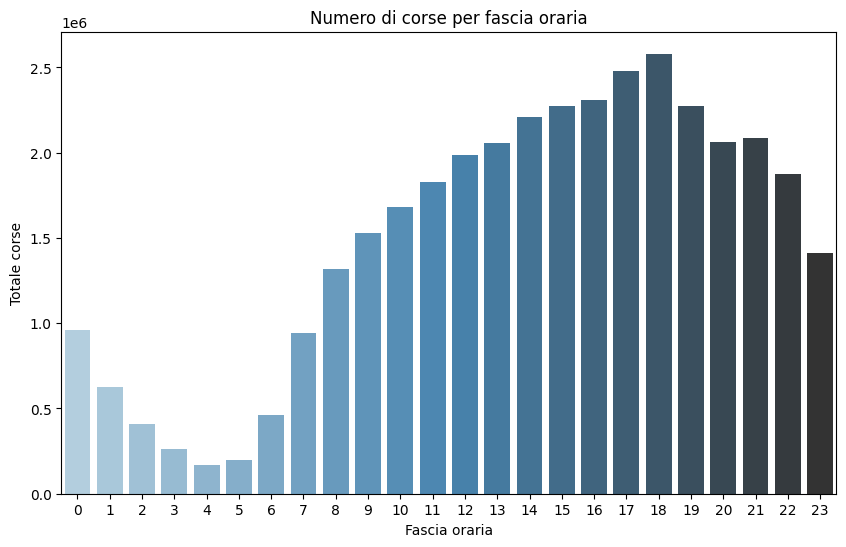

In [9]:
hourly_trips = df.groupBy("pickup_hour").count().orderBy("pickup_hour").toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="pickup_hour", y="count", data=hourly_trips, palette="Blues_d", hue="pickup_hour", legend=False)
plt.title("Numero di corse per fascia oraria")
plt.xlabel("Fascia oraria")
plt.ylabel("Totale corse")
plt.show()

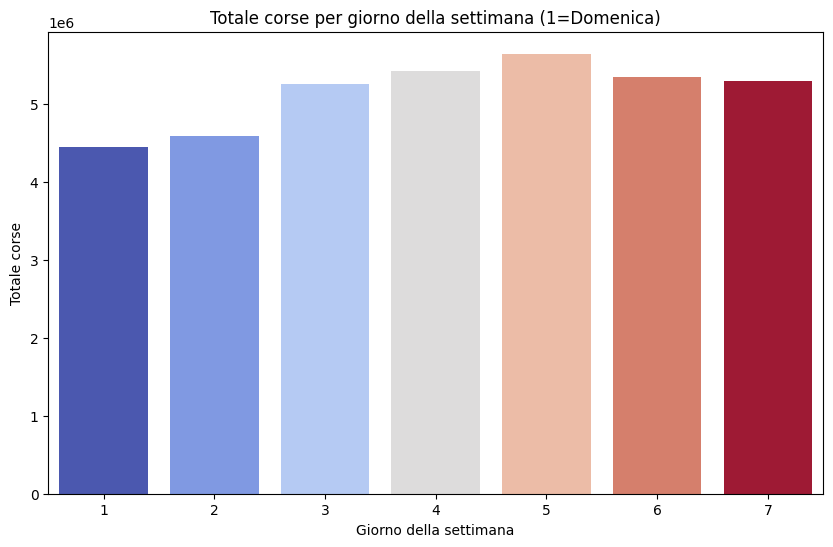

In [10]:
day_of_week = df.groupBy("pickup_day_of_week").count().orderBy("pickup_day_of_week").toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="pickup_day_of_week", y="count", data=day_of_week, palette="coolwarm",  hue="pickup_day_of_week", legend=False)
plt.title("Totale corse per giorno della settimana (1=Domenica)")
plt.xlabel("Giorno della settimana")
plt.ylabel("Totale corse")
plt.show()

In [19]:
bin_size = 0.5
df_with_bins = df.filter((col("trip_distance") > 0) & (col("trip_distance") < 20)) \
                 .withColumn("distance_bin", floor(col("trip_distance") / bin_size) * bin_size)

In [20]:
histogram_data = df_with_bins.groupBy("distance_bin") \
                             .agg(count("*").alias("frequency")) \
                             .orderBy("distance_bin")

In [27]:
histogram_data.orderBy(desc("frequency")).show(1)

+------------+---------+
|distance_bin|frequency|
+------------+---------+
|         1.0|  6945027|
+------------+---------+
only showing top 1 row



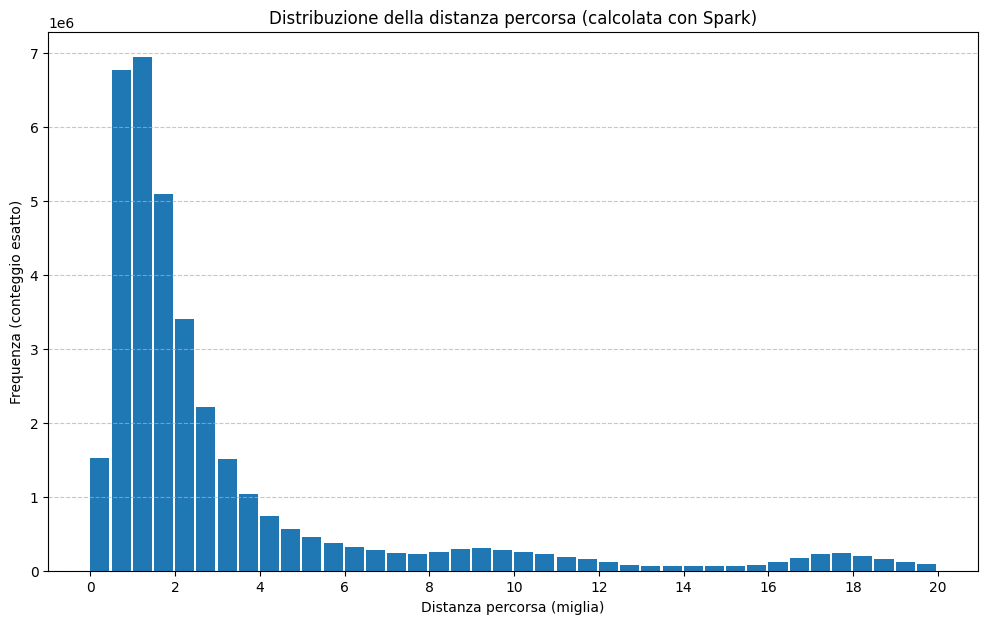

In [21]:
histogram_pandas_df = histogram_data.toPandas()
plt.figure(figsize=(12, 7))
plt.bar(histogram_pandas_df["distance_bin"], 
        histogram_pandas_df["frequency"], 
        width=bin_size * 0.9, # Make bars slightly narrower than the bin size
        align='edge')

plt.title("Distribuzione della distanza percorsa (calcolata con Spark)")
plt.xlabel("Distanza percorsa (miglia)")
plt.ylabel("Frequenza (conteggio esatto)")
plt.xticks(range(0, 21, 2))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()